In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/Cinema_Audience_Forecasting_challenge/movie_theater_id_relation/movie_theater_id_relation.csv
/kaggle/input/Cinema_Audience_Forecasting_challenge/date_info/date_info.csv
/kaggle/input/Cinema_Audience_Forecasting_challenge/sample_submission/sample_submission.csv
/kaggle/input/Cinema_Audience_Forecasting_challenge/booknow_theaters/booknow_theaters.csv
/kaggle/input/Cinema_Audience_Forecasting_challenge/cinePOS_booking/cinePOS_booking.csv
/kaggle/input/Cinema_Audience_Forecasting_challenge/cinePOS_theaters/cinePOS_theaters.csv
/kaggle/input/Cinema_Audience_Forecasting_challenge/booknow_visits/booknow_visits.csv
/kaggle/input/Cinema_Audience_Forecasting_challenge/booknow_booking/booknow_booking.csv


# Import Libraries

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.impute import KNNImputer
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import Ridge
import lightgbm as lgb
import xgboost as xgb

plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")



# Load Datasets 


In [3]:


booknow_visits = pd.read_csv("/kaggle/input/Cinema_Audience_Forecasting_challenge/booknow_visits/booknow_visits.csv")
booknow_booking = pd.read_csv("/kaggle/input/Cinema_Audience_Forecasting_challenge/booknow_booking/booknow_booking.csv")
cinePOS_booking = pd.read_csv("/kaggle/input/Cinema_Audience_Forecasting_challenge/cinePOS_booking/cinePOS_booking.csv")
date_info = pd.read_csv("/kaggle/input/Cinema_Audience_Forecasting_challenge/date_info/date_info.csv")
relation = pd.read_csv("/kaggle/input/Cinema_Audience_Forecasting_challenge/movie_theater_id_relation/movie_theater_id_relation.csv")
booknow_theaters = pd.read_csv("/kaggle/input/Cinema_Audience_Forecasting_challenge/booknow_theaters/booknow_theaters.csv")
cinePOS_theaters = pd.read_csv("/kaggle/input/Cinema_Audience_Forecasting_challenge/cinePOS_theaters/cinePOS_theaters.csv")
sample_submission = pd.read_csv("/kaggle/input/Cinema_Audience_Forecasting_challenge/sample_submission/sample_submission.csv")

print("datasets load")




datasets load


In [4]:
print(booknow_visits.head(3))
print(booknow_booking.head(3))
print(cinePOS_booking.head(3))
print(date_info.head(3))
print(relation.head(3))
print(booknow_theaters.head(3))
print(cinePOS_theaters.head(3))
print(sample_submission.head(3))

  book_theater_id   show_date  audience_count
0      book_00001  2023-01-13              50
1      book_00001  2023-01-14              64
2      book_00001  2023-01-15              58
  book_theater_id        show_datetime     booking_datetime  tickets_booked
0      book_00244  2023-01-01 19:00:00  2023-01-01 16:00:00               1
1      book_00740  2023-01-01 19:00:00  2023-01-01 19:00:00               3
2      book_00740  2023-01-01 19:00:00  2023-01-01 19:00:00               6
  cine_theater_id        show_datetime     booking_datetime  tickets_sold
0   cinePOS_00001  2023-01-01 11:00:00  2023-01-01 09:00:00             1
1   cinePOS_00002  2023-01-01 13:00:00  2023-01-01 06:00:00             3
2   cinePOS_00003  2023-01-01 16:00:00  2023-01-01 14:00:00             2
    show_date day_of_week
0  2023-01-01      Sunday
1  2023-01-02      Monday
2  2023-01-03     Tuesday
  book_theater_id cine_theater_id
0      book_00509   cinePOS_01261
1      book_00063   cinePOS_02467
2      boo

# EXPLORATORY DATA ANALYSIS - Data Overview 


In [5]:
print(f"booknow_visits: shape={booknow_visits.shape}")

print("\nMissing values:", booknow_visits.isnull().sum())
print(f"Date range: {booknow_visits['show_date'].min()} to {booknow_visits['show_date'].max()}")
print(f"Duplicate rows: {booknow_visits.duplicated().sum()}")
print(f"Unique theaters: {booknow_visits['book_theater_id'].nunique()}")

booknow_visits: shape=(214046, 3)

Missing values: book_theater_id    0
show_date          0
audience_count     0
dtype: int64
Date range: 2023-01-01 to 2024-02-28
Duplicate rows: 10
Unique theaters: 826


# EXPLORATORY DATA ANALYSIS - Audience count analysis



count    214046.00
mean         41.62
std          32.83
min           2.00
25%          18.00
50%          34.00
75%          58.00
max        1350.00
Name: audience_count, dtype: float64
IQR Oulier 
Lower bound: -42.0, Upper bound: 118.0, Outliers: 5589 (2.61%)


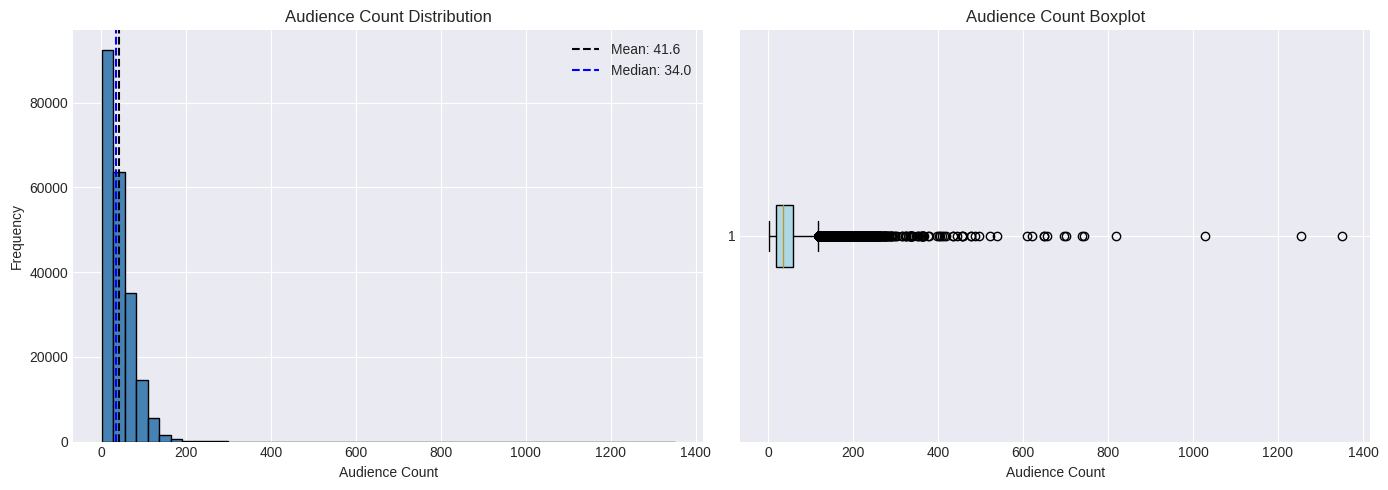

In [6]:
booknow_visits['audience_count'] = booknow_visits['audience_count'].astype(float)
aud = booknow_visits['audience_count']

print(aud.describe().round(2))

print("IQR Oulier ")
q1 = aud.quantile(0.25)
q3 = aud.quantile(0.75)
iqr = q3 - q1
lower_bound = q1 - 1.5 * iqr
upper_bound = q3 + 1.5 * iqr
outliers = aud[(aud < lower_bound) | (aud > upper_bound)]
print(f"Lower bound: {lower_bound}, Upper bound: {upper_bound}, Outliers: {len(outliers)} ({len(outliers)/len(aud)*100:.2f}%)")

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Histogram
axes[0].hist(aud, bins=50, color='steelblue', edgecolor='black')
axes[0].axvline(aud.mean(), color='black', linestyle='--', label=f'Mean: {aud.mean():.1f}')
axes[0].axvline(aud.median(), color='blue', linestyle='--', label=f'Median: {aud.median():.1f}')
axes[0].set_title('Audience Count Distribution')
axes[0].set_xlabel('Audience Count')
axes[0].set_ylabel('Frequency')
axes[0].legend()

# Boxplot
bp = axes[1].boxplot(aud, vert=False, patch_artist=True)
bp['boxes'][0].set_facecolor('lightblue')
bp['boxes'][0].set_edgecolor('black')
axes[1].set_title('Audience Count Boxplot')
axes[1].set_xlabel('Audience Count')

plt.tight_layout()
plt.show()


# EDA: Temporal Patterns in Audience Count

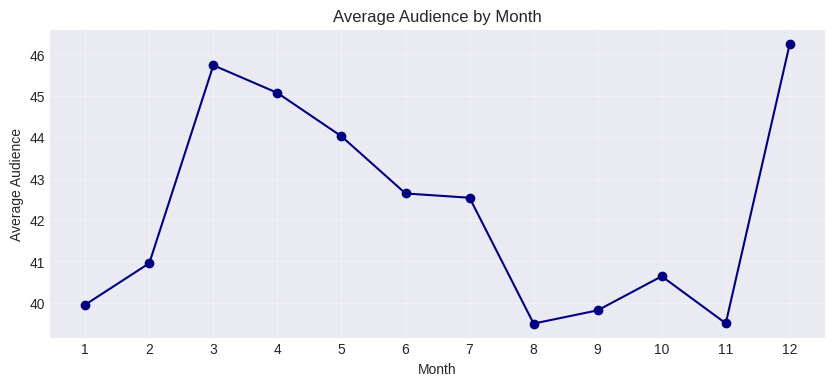

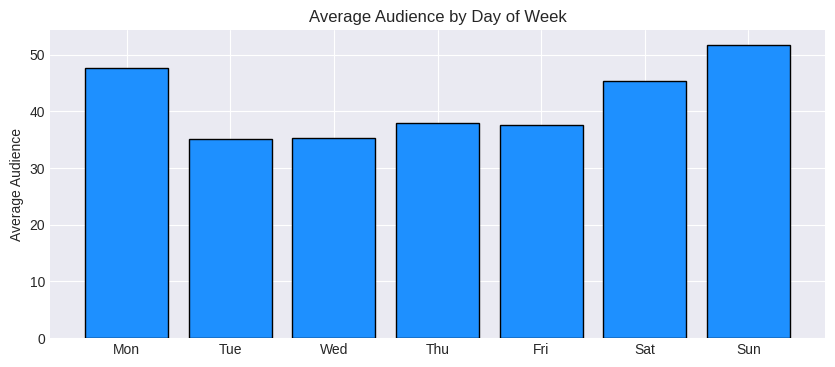

In [7]:
booknow_visits['show_date'] = pd.to_datetime(booknow_visits['show_date'])
booknow_visits['month'] = booknow_visits['show_date'].dt.month
booknow_visits['dow'] = booknow_visits['show_date'].dt.dayofweek

# Graph 2: Monthly average audience
monthly_avg = booknow_visits.groupby('month')['audience_count'].mean()

plt.figure(figsize=(10,4))
plt.plot(monthly_avg.index, monthly_avg.values, color='navy', marker='o')
plt.title("Average Audience by Month")
plt.xlabel("Month")
plt.ylabel("Average Audience")
plt.xticks(range(1,13))
plt.grid(alpha=0.3)
plt.show()

# Graph 3: Day of week average audience
dow_avg = booknow_visits.groupby('dow')['audience_count'].mean()
days_labels = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']

plt.figure(figsize=(10,4))
plt.bar(days_labels, dow_avg.values, color='dodgerblue', edgecolor='black')
plt.title("Average Audience by Day of Week")
plt.ylabel("Average Audience")
plt.show()


# EDA : Theater Category Analysis



Average Audience by Theater Type:
theater_type
Action    47.24
Comedy    47.01
Other     43.72
Drama     43.63
Name: audience_count, dtype: float64


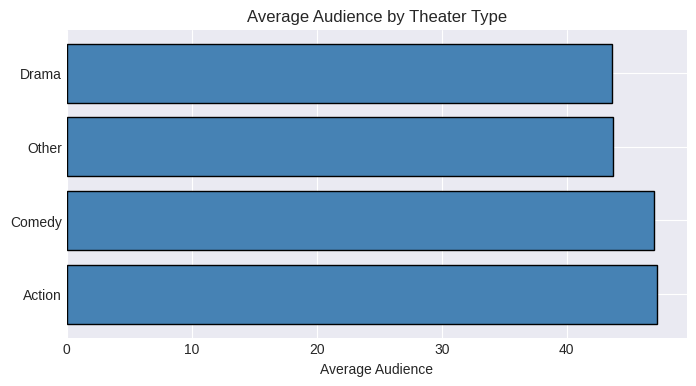

In [8]:
vis = booknow_visits.merge(booknow_theaters, on='book_theater_id', how='left')
type_avg = vis.groupby('theater_type')['audience_count'].mean().sort_values(ascending=False)

print("Average Audience by Theater Type:")
print(type_avg.round(2))

# Graph 4: Bar chart by theater type
plt.figure(figsize=(8,4))
plt.barh(type_avg.index, type_avg.values, color='steelblue', edgecolor='black')
plt.title("Average Audience by Theater Type")
plt.xlabel("Average Audience")
plt.show()


# EDA : Weekend vs Weekday Comparison

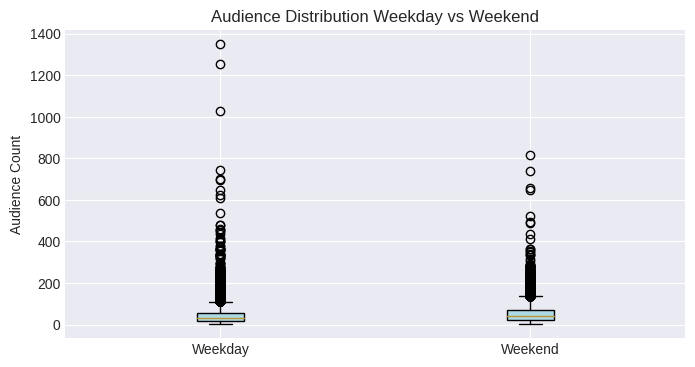

Weekday mean audience: 38.51
Weekend mean audience: 48.44
Weekend audience is 25.79% higher than weekday


In [9]:
weekend_aud = vis[vis['dow'].isin([5,6])]['audience_count']
weekday_aud = vis[~vis['dow'].isin([5,6])]['audience_count']

# Graph 5: Boxplot weekday vs weekend
plt.figure(figsize=(8,4))
bp = plt.boxplot([weekday_aud, weekend_aud], labels=['Weekday', 'Weekend'], patch_artist=True)
for patch in bp['boxes']:
    patch.set_facecolor('lightblue')
    patch.set_edgecolor('black')
plt.title("Audience Distribution Weekday vs Weekend")
plt.ylabel("Audience Count")
plt.show()

print(f"Weekday mean audience: {weekday_aud.mean():.2f}")
print(f"Weekend mean audience: {weekend_aud.mean():.2f}")
print(f"Weekend audience is {((weekend_aud.mean()/weekday_aud.mean()-1)*100):.2f}% higher than weekday")


# DATA PREPROCESSING¶


In [10]:
# Convert all date columns
booknow_visits['show_date'] = pd.to_datetime(booknow_visits['show_date'])
booknow_booking['show_datetime'] = pd.to_datetime(booknow_booking['show_datetime'])
booknow_booking['booking_datetime'] = pd.to_datetime(booknow_booking['booking_datetime'])
cinePOS_booking['show_datetime'] = pd.to_datetime(cinePOS_booking['show_datetime'])
cinePOS_booking['booking_datetime'] = pd.to_datetime(cinePOS_booking['booking_datetime'])
date_info['show_date'] = pd.to_datetime(date_info['show_date'])

# Calculate global statistics
global_mean = booknow_visits['audience_count'].mean()
print(global_mean)


41.61656840118479


# FEATURE ENGINEERING - PART 1: BOOKING FEATURES

In [11]:
booknow_booking['show_date'] = pd.to_datetime(booknow_booking['show_datetime'].dt.date)
booknow_booking['lead_time_days'] = (booknow_booking['show_datetime'] - booknow_booking['booking_datetime']).dt.total_seconds() / 86400

booking_features = booknow_booking.groupby(['book_theater_id', 'show_date']).agg({
    'tickets_booked': ['sum', 'mean', 'count', 'std', 'max'],
    'lead_time_days': ['mean', 'std', 'max']
}).reset_index()
booking_features.columns = ['_'.join(col).strip('_') if col[1] else col[0] for col in booking_features.columns.values]
booking_features.fillna(0, inplace=True)

print(f"\nBooking features created: {booking_features.shape}")
print(booking_features.head())


Booking features created: (21590, 10)
  book_theater_id  show_date  tickets_booked_sum  tickets_booked_mean  \
0      book_00004 2023-02-27                  12            12.000000   
1      book_00013 2023-01-04                   2             2.000000   
2      book_00013 2023-01-08                   3             3.000000   
3      book_00013 2023-01-09                  25             2.083333   
4      book_00013 2023-01-10                   5             2.500000   

   tickets_booked_count  tickets_booked_std  tickets_booked_max  \
0                     1            0.000000                  12   
1                     1            0.000000                   2   
2                     1            0.000000                   3   
3                    12            0.792961                   4   
4                     2            0.707107                   3   

   lead_time_days_mean  lead_time_days_std  lead_time_days_max  
0             0.041667            0.000000            

# FEATURE ENGINEERING - PART 2: Pos sales data features

In [12]:
cinePOS_booking['show_date'] = pd.to_datetime(cinePOS_booking['show_datetime'].dt.date)
cinePOS_mapped = cinePOS_booking.merge(relation, on='cine_theater_id', how='inner')

pos_features = cinePOS_mapped.groupby(['book_theater_id', 'show_date']).agg({
    'tickets_sold': ['sum', 'mean', 'std']
}).reset_index()
pos_features.columns = ['_'.join(col).strip('_') if col[1] else col[0] for col in pos_features.columns.values]
pos_features.fillna(0, inplace=True)

print(f"\nPOS features created: {pos_features.shape}")
print(pos_features.head())



POS features created: (15789, 5)
  book_theater_id  show_date  tickets_sold_sum  tickets_sold_mean  \
0      book_00015 2023-03-28                 2                2.0   
1      book_00015 2023-04-02                 2                2.0   
2      book_00015 2023-04-09                 3                3.0   
3      book_00015 2023-04-12                 2                2.0   
4      book_00015 2023-04-15                 2                2.0   

   tickets_sold_std  
0               0.0  
1               0.0  
2               0.0  
3               0.0  
4               0.0  


# FEATURE ENGINEERING - PART 3: BASE TRAIN_DF + TIME FEATURES + STATS + INTERACTIONS


In [13]:
train_df = booknow_visits.copy()
train_df = train_df.merge(date_info, on='show_date', how='left')
train_df = train_df.merge(booknow_theaters, on='book_theater_id', how='left')
train_df = train_df.merge(booking_features, on=['book_theater_id', 'show_date'], how='left')
train_df = train_df.merge(pos_features, on=['book_theater_id', 'show_date'], how='left')
train_df.fillna(0, inplace=True)

print(f"\nBase dataframe created: {train_df.shape}")

# 1. Time based features
train_df['month'] = train_df['show_date'].dt.month
train_df['dayofweek'] = train_df['show_date'].dt.dayofweek
train_df['is_weekend'] = train_df['dayofweek'].isin([5, 6]).astype(int)
train_df['is_friday'] = (train_df['dayofweek'] == 4).astype(int)
train_df['day_of_year'] = train_df['show_date'].dt.dayofyear

# 2. Cyclical encoding
train_df['month_sin'] = np.sin(2 * np.pi * train_df['month'] / 12)
train_df['month_cos'] = np.cos(2 * np.pi * train_df['month'] / 12)
train_df['dow_sin'] = np.sin(2 * np.pi * train_df['dayofweek'] / 7)
train_df['dow_cos'] = np.cos(2 * np.pi * train_df['dayofweek'] / 7)

# 3. Statistical aggregations
theater_type_stats = train_df.groupby('theater_type')['audience_count'].agg(['mean', 'std']).reset_index()
theater_type_stats.columns = ['theater_type', 'type_mean', 'type_std']

theater_area_stats = train_df.groupby('theater_area')['audience_count'].agg(['mean', 'std']).reset_index()
theater_area_stats.columns = ['theater_area', 'area_mean', 'area_std']

theater_id_stats = train_df.groupby('book_theater_id')['audience_count'].agg(['mean', 'std']).reset_index()
theater_id_stats.columns = ['book_theater_id', 'theater_id_mean', 'theater_id_std']

train_df = train_df.merge(theater_type_stats, on='theater_type', how='left')
train_df = train_df.merge(theater_area_stats, on='theater_area', how='left')
train_df = train_df.merge(theater_id_stats, on='book_theater_id', how='left')

# 4. Interaction features
train_df['tickets_per_booking'] = train_df['tickets_booked_sum'] / (train_df['tickets_booked_count'] + 1)
train_df['pos_ratio'] = train_df['tickets_sold_sum'] / (train_df['tickets_booked_sum'] + 1)
train_df['weekend_type'] = train_df['is_weekend'] * train_df['type_mean']

print(train_df.shape)
print(train_df.head())


Base dataframe created: (214046, 21)
(214046, 38)
  book_theater_id  show_date  audience_count  month  dow day_of_week  \
0      book_00001 2023-01-13            50.0      1    4      Friday   
1      book_00001 2023-01-14            64.0      1    5    Saturday   
2      book_00001 2023-01-15            58.0      1    6      Sunday   
3      book_00001 2023-01-16            44.0      1    0      Monday   
4      book_00001 2023-01-18            12.0      1    2   Wednesday   

  theater_type theater_area  latitude  longitude  ...   dow_cos  type_mean  \
0        Drama     Area_002  23.00441  79.934515  ... -0.900969  43.627634   
1        Drama     Area_002  23.00441  79.934515  ... -0.222521  43.627634   
2        Drama     Area_002  23.00441  79.934515  ...  0.623490  43.627634   
3        Drama     Area_002  23.00441  79.934515  ...  1.000000  43.627634   
4        Drama     Area_002  23.00441  79.934515  ... -0.222521  43.627634   

    type_std  area_mean   area_std  theater_id_

# FEATURE ENGINEERING PART 4: Time Series Feature Forecaste


In [14]:
train_df = train_df.sort_values(['book_theater_id', 'show_date']).reset_index(drop=True)

# 1. Lag features
lags = [1, 7, 14, 28]
for lag in lags:
    train_df[f'lag_{lag}'] = train_df.groupby('book_theater_id')['audience_count'].shift(lag)
print(f"   Created {len(lags)} lag features: {lags}")

# 2. Rolling statistics
windows = [7, 14, 30]
for window in windows:
    train_df[f'roll_mean_{window}'] = train_df.groupby('book_theater_id')['audience_count'].shift(1).rolling(window, min_periods=1).mean()
    train_df[f'roll_std_{window}'] = train_df.groupby('book_theater_id')['audience_count'].shift(1).rolling(window, min_periods=1).std()
print(f"   Created {len(windows)*2} rolling features (windows: {windows})")

# 3. Exponential weighted moving average
spans = [7, 21]
for span in spans:
    train_df[f'ewm_{span}'] = train_df.groupby('book_theater_id')['audience_count'].shift(1).ewm(span=span, adjust=False).mean()
print(f"   Created {len(spans)} EWM features (spans: {spans})")

# 4. Trend & momentum features
train_df['trend_7_14'] = train_df['roll_mean_7'] - train_df['roll_mean_14']
train_df['momentum_1_7'] = train_df['lag_1'] - train_df['lag_7']

total_features = train_df.shape[1] - booknow_visits.shape[1]
print(f"Total features engineered: {total_features}")
print(f"Final training shape: {train_df.shape}")

print(train_df.head())

   Created 4 lag features: [1, 7, 14, 28]
   Created 6 rolling features (windows: [7, 14, 30])
   Created 2 EWM features (spans: [7, 21])
Total features engineered: 47
Final training shape: (214046, 52)
  book_theater_id  show_date  audience_count  month  dow day_of_week  \
0      book_00001 2023-01-13            50.0      1    4      Friday   
1      book_00001 2023-01-14            64.0      1    5    Saturday   
2      book_00001 2023-01-15            58.0      1    6      Sunday   
3      book_00001 2023-01-16            44.0      1    0      Monday   
4      book_00001 2023-01-18            12.0      1    2   Wednesday   

  theater_type theater_area  latitude  longitude  ...  roll_mean_7  \
0        Drama     Area_002  23.00441  79.934515  ...          NaN   
1        Drama     Area_002  23.00441  79.934515  ...    50.000000   
2        Drama     Area_002  23.00441  79.934515  ...    57.000000   
3        Drama     Area_002  23.00441  79.934515  ...    57.333333   
4        Drama

# DATA ENCODING & PREPARATION

In [15]:
# 1. LABEL ENCODING  
categorical_cols = ['book_theater_id', 'day_of_week', 'theater_type', 'theater_area']
label_encoders = {}
for col in categorical_cols:
    le = LabelEncoder()
    train_df[col] = le.fit_transform(train_df[col].fillna('unknown').astype(str))
    label_encoders[col] = le
    print(f"   - {col}: {len(le.classes_)} ")


# 2. FEATURE MATRIX x and TARGET VECTOR y


feature_cols = [
    col for col in train_df.columns 
    if col not in ['audience_count', 'show_date', 'theater_area']
]

X_train = train_df[feature_cols].copy()
y_train = train_df['audience_count'].copy()

print(f"Total input feature {len(feature_cols)}")
print(f" X_train shape {X_train.shape}")
print(f" y_train shape {y_train.shape}")


# 3. MISSING VALUE HANDLING (KNN Imputer)

imputer = KNNImputer(n_neighbors=5, weights='distance')
X_train = pd.DataFrame(imputer.fit_transform(X_train), columns=X_train.columns)

print(" Knn done")


# 4. FEATURE SCALING (StandardScaler)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)




print(f"Final Feature Matrix Shape: {X_train.shape}")
print(f"Target Vector Shape: {y_train.shape}")
print(f"Total Features Used for Training: {len(feature_cols)}")


   - book_theater_id: 826 
   - day_of_week: 7 
   - theater_type: 5 
   - theater_area: 72 
Total input feature 49
 X_train shape (214046, 49)
 y_train shape (214046,)
 Knn done
Final Feature Matrix Shape: (214046, 49)
Target Vector Shape: (214046,)
Total Features Used for Training: 49


In [16]:
print(X_train.head())
print(y_train.head())

   book_theater_id  month  dow  day_of_week  theater_type  latitude  \
0              0.0    1.0  4.0          0.0           3.0  23.00441   
1              0.0    1.0  5.0          2.0           3.0  23.00441   
2              0.0    1.0  6.0          3.0           3.0  23.00441   
3              0.0    1.0  0.0          1.0           3.0  23.00441   
4              0.0    1.0  2.0          6.0           3.0  23.00441   

   longitude  tickets_booked_sum  tickets_booked_mean  tickets_booked_count  \
0  79.934515                 0.0                  0.0                   0.0   
1  79.934515                 0.0                  0.0                   0.0   
2  79.934515                 0.0                  0.0                   0.0   
3  79.934515                 0.0                  0.0                   0.0   
4  79.934515                 0.0                  0.0                   0.0   

   ...  roll_mean_7  roll_std_7  roll_mean_14  roll_std_14  roll_mean_30  \
0  ...    43.946601   

# HYPERPARAMETER TUNING

In [19]:
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV

print("RIDGE REGRESSION")

param_grid = {
    "alpha": [0.01, 0.05, 0.1, 0.5, 1.0, 5.0, 10.0]
}

ridge = Ridge(max_iter=5000)

grid_search = GridSearchCV(
    estimator=ridge,
    param_grid=param_grid,
    cv=5,
    scoring="r2",
    n_jobs=-1,
    verbose=1
)

grid_search.fit(X_train, y_train)

print("Best Ridge params:", grid_search.best_params_)
print("Best CV R2 score:", grid_search.best_score_)


RIDGE REGRESSION
Fitting 5 folds for each of 7 candidates, totalling 35 fits
Best Ridge params: {'alpha': 1.0}
Best CV R2 score: 0.498713567374346


# MODEL TRAINING - ALL 3 MODELS

In [20]:
# Train Ridge
ridge = Ridge(alpha=0.1, max_iter=5000)
ridge.fit(X_train_scaled, y_train)

# Train LightGBM
lgbm = lgb.LGBMRegressor(
    n_estimators=300,
    learning_rate=0.05,
    num_leaves=31,
    max_depth=7,
    min_child_samples=20,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    verbosity=-1,
    n_jobs=-1
)
lgbm.fit(X_train, y_train)

# Train XGBoost
xgboost = xgb.XGBRegressor(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=7,
    min_child_weight=3,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    verbosity=0,
    n_jobs=-1
)
xgboost.fit(X_train, y_train)

print("\nAll 3 models trained successfully!")


All 3 models trained successfully!


# MODEL EVALUATION & COMPARISON

In [21]:
# Get predictions
ridge_pred = ridge.predict(X_train_scaled)
lgbm_pred = lgbm.predict(X_train)
xgb_pred = xgboost.predict(X_train)

# Calculate metrics
ridge_r2 = r2_score(y_train, ridge_pred)
ridge_rmse = np.sqrt(mean_squared_error(y_train, ridge_pred))

lgbm_r2 = r2_score(y_train, lgbm_pred)
lgbm_rmse = np.sqrt(mean_squared_error(y_train, lgbm_pred))

xgb_r2 = r2_score(y_train, xgb_pred)
xgb_rmse = np.sqrt(mean_squared_error(y_train, xgb_pred))

# Ensemble
ensemble_train_pred = 0.15 * ridge_pred + 0.35 * lgbm_pred + 0.50 * xgb_pred
ensemble_r2 = r2_score(y_train, ensemble_train_pred)
ensemble_rmse = np.sqrt(mean_squared_error(y_train, ensemble_train_pred))

# Display results
print("\n" + "="*100)
print("MODEL PERFORMANCE COMPARISON")
print("="*100)
print(f"\nRidge Regression:")
print(f"   R2 Score: {ridge_r2:.4f}")
print(f"   RMSE: {ridge_rmse:.4f}")

print(f"\nLightGBM:")
print(f"   R2 Score: {lgbm_r2:.4f}")
print(f"   RMSE: {lgbm_rmse:.4f}")

print(f"\nXGBoost:")
print(f"   R2 Score: {xgb_r2:.4f}")
print(f"   RMSE: {xgb_rmse:.4f}")

print(f"   R2 Score: {ensemble_r2:.4f}")
print(f"   RMSE: {ensemble_rmse:.4f}")



MODEL PERFORMANCE COMPARISON

Ridge Regression:
   R2 Score: 0.5089
   RMSE: 23.0106

LightGBM:
   R2 Score: 0.5799
   RMSE: 21.2827

XGBoost:
   R2 Score: 0.6426
   RMSE: 19.6308
   R2 Score: 0.6096
   RMSE: 20.5159


# TEST DATA PREPARATION


In [22]:
# Parse test IDs
sample_submission['book_theater_id'] = 'book_' + sample_submission['ID'].str.split('_').str[1]
sample_submission['show_date'] = pd.to_datetime(sample_submission['ID'].str.split('_').str[2])
test_df = sample_submission[['ID', 'book_theater_id', 'show_date']].copy()

print(f"\nTest dataframe created: {test_df.shape}")

# Apply same transformations
test_df['month'] = test_df['show_date'].dt.month
test_df['dayofweek'] = test_df['show_date'].dt.dayofweek
test_df['is_weekend'] = test_df['dayofweek'].isin([5, 6]).astype(int)
test_df['is_friday'] = (test_df['dayofweek'] == 4).astype(int)
test_df['day_of_year'] = test_df['show_date'].dt.dayofyear

# Merge features
test_df = test_df.merge(date_info, on='show_date', how='left')
test_df = test_df.merge(booknow_theaters, on='book_theater_id', how='left')
test_df = test_df.merge(booking_features, on=['book_theater_id', 'show_date'], how='left')
test_df = test_df.merge(pos_features, on=['book_theater_id', 'show_date'], how='left')
test_df = test_df.merge(theater_type_stats, on='theater_type', how='left')
test_df = test_df.merge(theater_area_stats, on='theater_area', how='left')
test_df = test_df.merge(theater_id_stats, on='book_theater_id', how='left')
test_df.fillna(0, inplace=True)

# Cyclical features
test_df['month_sin'] = np.sin(2 * np.pi * test_df['month'] / 12)
test_df['month_cos'] = np.cos(2 * np.pi * test_df['month'] / 12)
test_df['dow_sin'] = np.sin(2 * np.pi * test_df['dayofweek'] / 7)
test_df['dow_cos'] = np.cos(2 * np.pi * test_df['dayofweek'] / 7)

# Interactions
test_df['tickets_per_booking'] = test_df['tickets_booked_sum'] / (test_df['tickets_booked_count'] + 1)
test_df['pos_ratio'] = test_df['tickets_sold_sum'] / (test_df['tickets_booked_sum'] + 1)
test_df['weekend_type'] = test_df['is_weekend'] * test_df['type_mean']

print(f"   Base features applied")


Test dataframe created: (38062, 3)
   Base features applied


# TEST ENCODING & FINAL PREPARATION¶


In [23]:


# Encode categorical
for col in categorical_cols:
    le = label_encoders[col]
    test_df[col] = test_df[col].fillna('unknown').astype(str).apply(
        lambda x: le.transform([x])[0] if x in le.classes_ else -1
    )
print(f"   All categorical features encoded")

# Align features
for col in feature_cols:
    if col not in test_df.columns:
        test_df[col] = 0

X_test = test_df[feature_cols].copy()
X_test = pd.DataFrame(imputer.transform(X_test), columns=X_test.columns)
X_test_scaled = scaler.transform(X_test)

print(f"\nTest preparation complete!")
print(f"Test feature matrix: {X_test.shape}")


   All categorical features encoded

Test preparation complete!
Test feature matrix: (38062, 49)


In [ ]:
print(X_test.head())

# ENSEMBLE PREDICTION & SUBMISSION¶


In [24]:
print("\nGenerating predictions from all models...")
ridge_test_pred = ridge.predict(X_test_scaled)
lgbm_test_pred = lgbm.predict(X_test)
xgb_test_pred = xgboost.predict(X_test)

print(f"   Ridge predictions: mean={ridge_test_pred.mean():.2f}")
print(f"   LightGBM predictions: mean={lgbm_test_pred.mean():.2f}")
print(f"   XGBoost predictions: mean={xgb_test_pred.mean():.2f}")

# Create ensemble
print("\nCreating weighted ensemble...")
ensemble_pred = 0.15 * ridge_test_pred + 0.35 * lgbm_test_pred + 0.50 * xgb_test_pred
ensemble_pred = np.clip(ensemble_pred, 0, 200)



# Create submission
submission = pd.DataFrame({
    'ID': test_df['ID'],
    'audience_count': ensemble_pred
})
submission.to_csv('submission.csv', index=False)


print(f"\nPrediction Statistics:")
print(f"   Mean: {ensemble_pred.mean():.2f}")
print(f"   Median: {np.median(ensemble_pred):.2f}")
print(f"   Std Dev: {ensemble_pred.std():.2f}")
print(f"   Min: {ensemble_pred.min():.2f}")
print(f"   Max: {ensemble_pred.max():.2f}")


print(f"   Shape: {submission.shape}")

print(submission.head(10))


Generating predictions from all models...
   Ridge predictions: mean=16.61
   LightGBM predictions: mean=23.30
   XGBoost predictions: mean=29.27

Creating weighted ensemble...

Prediction Statistics:
   Mean: 25.28
   Median: 18.36
   Std Dev: 17.15
   Min: 0.84
   Max: 98.34
   Shape: (38062, 2)
                      ID  audience_count
0  book_00001_2024-03-01       19.064437
1  book_00001_2024-03-02       22.011530
2  book_00001_2024-03-03       23.208471
3  book_00001_2024-03-04       23.124028
4  book_00001_2024-03-06       20.702471
5  book_00001_2024-03-07       20.878901
6  book_00001_2024-03-08       19.145482
7  book_00001_2024-03-09       22.211284
8  book_00001_2024-03-10       23.408225
9  book_00001_2024-03-11       23.479994
